In [121]:
# Standard library imports
import os
from PIL import Image

# Third-party library imports
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [122]:
data_dir = 'data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

print(sorted(classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [123]:
X = []
y = []

for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    print(f'{c}: {len(files)}')

    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        img = img.resize((28, 28))
        img = np.array(img)
        img = img / 255
        img = img.astype(np.float32)
        # Check the shape of the image after resizing
        print(img.shape)
        X.append(img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

9: 100
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 

In [124]:
# print the shape of the arrays
print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Save the data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('classes.npy', classes)

print('Data saved')


(1000, 28, 28, 4)
(1000,)
Data saved


In [125]:
# Load the data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy')

print('Data loaded')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(sorted(classes))



Data loaded
(800, 28, 28, 4)
(200, 28, 28, 4)
(800, 10)
(200, 10)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


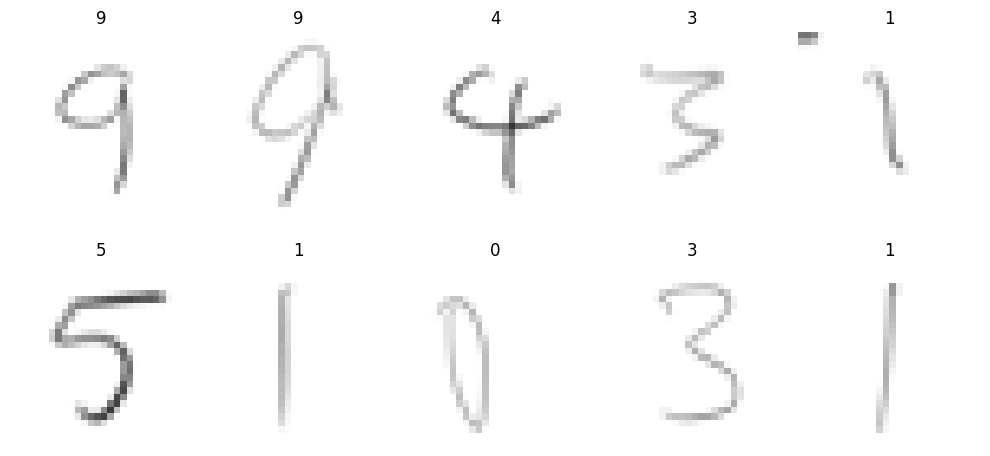

In [126]:
# print a random sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [174]:
# data augmentation
datagen = ImageDataGenerator(
      rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

augmented_X = []
augmented_y = []

# Generate augmented data for each sample in the dataset
for i in range(len(X_train)):
    X_train_example = X_train[i].reshape((1, 28, 28, 4))
    y_train_example = y_train[i].reshape((1, 10))
    num_augmented_samples = 5  # You can adjust the number of augmented samples per original sample
    for _ in range(num_augmented_samples):
        X_train_augmented, y_train_augmented = datagen.flow(X_train_example, y_train_example).__next__()
        # Reshape augmented data to remove extra dimension
        X_train_augmented = X_train_augmented.squeeze(axis=0)
        y_train_augmented = y_train_augmented.squeeze(axis=0)
        augmented_X.append(X_train_augmented)
        augmented_y.append(y_train_augmented)

# Convert lists to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Print the shape of the augmented dataset
print("Shape of augmented dataset:", augmented_X.shape)
print("Shape of augmented labels:", augmented_y.shape)

# PREVIEW AUGMENTED IMAGES
#X_train3 = X_train[799,].reshape((1,28,28,4))
#Y_train3 = y_train[799,].reshape((1,10))

# PREVIEW AUGMENTED IMAGES FOR THE WHOLE DATASET
#plt.figure(figsize=(15, 4.5))
#for i in range(len(X_train)):
    #plt.subplot(3, 10, i % 30 + 1)  # Limiting to show 30 images
#    X_train_example = X_train[i].reshape((1, 28, 28, 4))
#    Y_train_example = y_train[i].reshape((1, 10))
#    X_train_augmented, y_train_augmented = datagen.flow(X_train_example, Y_train_example).__next__()
    #X_train_augmented_resized = cv2.resize(X_train_augmented[0], (28, 28))
    #plt.imshow(X_train_augmented, cmap=plt.cm.binary)
    #plt.axis('off')
    #if i % 30 == 29:
    #    break  # Exit loop after displaying 30 images
#plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
#plt.show()

# Print the new shape of the data after augmentation
#print("Shape of augmented dataset:", X_train_augmented.size)
#print("Shape of augmented dataset:", y_train_augmented.size)

Shape of augmented dataset: (4000, 28, 28, 4)
Shape of augmented labels: (4000, 10)


In [175]:
def intialize_model_train(epoch, batch_size):
	model = Sequential()
	model.add(Conv2D(6, kernel_size=(5, 5), padding="valid", activation='relu', input_shape=(28, 28, 4)))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Conv2D(16, kernel_size=(5, 5), padding="valid", activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Flatten())
	model.add(Dense(120, activation='relu'))
	#model.add(Dropout(0.5))
	model.add(Dense(84, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))

	print("******* training network *******")
# Compile the model with Adam optimizer
	adam_optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
	model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
	# go through the data 5 times with 128 batch sizes
	H = model.fit(augmented_X,augmented_y, validation_data=(X_test, y_test),
		epochs=epoch, batch_size=batch_size)

	# evaluate the network
	print("******* evaluating network *******")
	predictions = model.predict(X_test, batch_size=batch_size)
	print(classification_report(y_test.argmax(axis=1),
		predictions.argmax(axis=1)))

In [179]:
intialize_model_train(8,50)

******* training network *******
Epoch 1/8
80/80 [==============================] - 4s 29ms/step - loss: 2.2557 - accuracy: 0.1452 - val_loss: 2.0228 - val_accuracy: 0.3050
Epoch 2/8
80/80 [==============================] - 2s 30ms/step - loss: 1.9432 - accuracy: 0.3358 - val_loss: 1.5975 - val_accuracy: 0.6000
Epoch 3/8
80/80 [==============================] - 2s 24ms/step - loss: 1.6848 - accuracy: 0.4600 - val_loss: 1.3030 - val_accuracy: 0.6050
Epoch 4/8
80/80 [==============================] - 2s 21ms/step - loss: 1.4904 - accuracy: 0.5132 - val_loss: 1.0768 - val_accuracy: 0.6850
Epoch 5/8
80/80 [==============================] - 3s 35ms/step - loss: 1.2920 - accuracy: 0.5685 - val_loss: 0.9165 - val_accuracy: 0.7300
Epoch 6/8
80/80 [==============================] - 2s 22ms/step - loss: 1.1527 - accuracy: 0.6202 - val_loss: 0.8185 - val_accuracy: 0.7500
Epoch 7/8
80/80 [==============================] - 2s 24ms/step - loss: 1.0260 - accuracy: 0.6535 - val_loss: 0.6958 - val_accu